### compare
- deeponet
- fno
- fcn

In [1]:
item = 'random_best_3'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.io as scio
import torch
import torch.nn as nn
from torchinfo import summary
from timeit import default_timer
import sys
sys.path.append("../scripts/")
sys.path.append("../run/")
import yaml
from utilities import *
from deeponet_2d import *
# from fourier_2d import *
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

### plot parameters

In [3]:
with open( '../run/config.yml') as f:
    config = yaml.full_load(f)
config = config[item]
device = torch.device('cpu')
TRAIN_PATH = config['TRAIN_PATH']
TEST_PATH  = config['TEST_PATH']
save_mode  = config['save_mode']
n_out      = config['n_out'] # rhoxy,phsxy,rhoyx,phsyx
model_path = "../model/"+config['name']+ "_"+str(n_out) # save path and name of model
model_path_temp = "../temp/"+config['name']+"_"+ str(n_out)
log_path = "../Log/"+config['name']+"_"+str(n_out)+'.log'

ntrain = config['ntrain']
ntest  = config['ntest']

batch_size = config['batch_size']
learning_rate = config['learning_rate']

epochs = config['epochs']
step_size = config['step_size']
gamma = config['gamma']

modes = config['modes']
width = config['width']

s_train = config['s_train']
r_train = config['r_train']
s_test = config['s_test']
r_test = config['r_test']
layer_num = config['layer_num']
last_size = config['last_size'] 
act_fno   = config['act_fno']

layer_sizes = config['layer_sizes']+[s_train[0]*s_train[1]]
act_func  = config['act_func']
init_func = config['init_func']
    

patience = config['patience'] # if there is {patience} epoch that val_error is larger, early stop,
thre_epoch = config['thre_epoch']# condiser early stop after {thre_epoch} epochs

print_model_flag = config['print_model_flag'] # 

In [4]:
loc_train,loc_test,train_loader, test_loader, x_normalizer,y_normalizer = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]

begin to read data
reading finished in 12.205 s


### 1. load deeponet

In [5]:
if os.path.exists(model_path+'.pt'):
    model=torch.load(model_path+'.pt',map_location=device)
elif os.path.exists(model_path+'.pkl'):
    model=deeponet(layer_sizes, act_func, init_func,modes, modes, width,\
        n_out,layer_num, last_size, act_fno).to(device)
    model.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss(size_average=False)

In [6]:
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    x, y = sample[0].to(device), sample[1].to(device)


    out = model(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
    input_size = s_test[2]*s_test[3]
    n_out = y.shape[-1]
    out = torch.cat(([out[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
            for i in range(n_out)]),-1)
    out = y_normalizer.decode(out)

    test_l2 += myloss(out, y).item()

test_l2 /= len(x)
t2 = default_timer()
print(t2-t1, test_l2)

0.6302590565755963 0.003677111268043518


### 2. fno

In [8]:
from fourier_2d import FNO2d
model_path_fno = "../model/"+"random_fno"+ "_3_"+str(n_out)
if os.path.exists(model_path_fno+'.pt'):
    model_fno=torch.load(model_path_fno+'.pt',map_location=device)
elif os.path.exists(model_path_fno+'.pkl'):
    model_fno=FNO2d(modes, modes, width,n_out,layer_num, last_size, act_fno).to(device)
    model_fno.load_state_dict(torch.load(model_path_fno+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss(size_average=False)

model_fno.eval()
model_fno.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
with torch.no_grad():
    x, y = sample[0].to(device), sample[1].to(device)

    out_fno = model_fno(x)#.reshape(batch_size, s[2],s[3],-1)
    out_fno = y_normalizer.decode(out_fno)
    test_l2 += myloss(out_fno, y).item()

test_l2 /= len(x)

t2 = default_timer()
print(t2-t1, test_l2)

0.582035874016583 0.002645100951194763


### 3. fcn

In [9]:
from EFCN_2d import *
item = 'E_best_3'
with open( '../run/config_E.yml') as f:
    config = yaml.full_load(f)
config = config[item]

device = "cpu"

config['layer_sizes'] =  config['layer_sizes'] + [64*64]
config['model_path'] = "../model/"+item
config['model_path_temp'] = "../temp/"+item
config['log_path'] = "../Log/"+item+'.log'

# model_path_cnn = "../model/E_best"
if os.path.exists(config['model_path']+'.pkl'):
    model_cnn = EDenseED(config['layer_sizes'], 
                    config['act_func'], config['init_func'],
                    in_channels=1, out_channels=4, 
                    imsize=config['imsize'],
                    blocks=config['blocks'],
                    growth_rate  =config['growth_rate'],
                    init_features=config['init_features'],
                    drop_rate    =config['drop_rate'],
                    out_activation=None,
                    upsample=config['upsample'])
    model_cnn.load_state_dict(torch.load(config['model_path']+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')

myloss = LpLoss(size_average=False)


# params 3286980, # conv layers 50


In [10]:
_,_,_,y_normalizer_cnn = \
load_E_data(config['train_file'] ,config['test_file'] ,config['ntest'],\
          config['ntest'],config['batch_size'])

begin to read data
reading finished in 13.714 s


In [11]:
model_cnn.eval()
model_cnn.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    x, y = sample[0].permute(0,3,1,2).to(device), sample[1].to(device)

    batch_size = len(x)
    nz,ny = y.shape[-2],y.shape[-3]
    out_cnn = model_cnn(x,loc_test)#.reshape(batch_size, s[2],s[3],-1)
    input_size = nz * ny
    n_out = y.shape[-1]
    out_cnn = torch.cat(([out_cnn[:,i*input_size:(i+1)*input_size].reshape(batch_size,-1,nz,ny) for i in range(n_out)]),1)
    out_cnn = y_normalizer_cnn.decode(out_cnn).permute(0,2,3,1)

    test_l2 += myloss(out_cnn, y).item()

test_l2 /= len(x)
x = x.permute(0,2,3,1)

t2 = default_timer()
print(t2-t1, test_l2)

3.061129454523325 0.007841897010803223


In [12]:
def error_r(x1,x0):
    '''relative error 
    x1 : prediction
    x0 : exact
    '''
    return np.linalg.norm(x1-x0)/np.linalg.norm(x0)

Relative rhoxy,rhoyx, phsxy,phsyx error:  0.0030681612 0.00525985 0.0063428907 0.012147542
Relative rhoxy_fno,rhoyx_fno, phsxy_fno,phsyx_fno  error:  0.012740415 0.0146456845 0.011207997 0.011207997
Relative rhoxy_cnn,rhoyx_cnn, phsxy_cnn,phsyx_cnn  error:  0.008446854 0.010282456 0.024626236 0.024626236


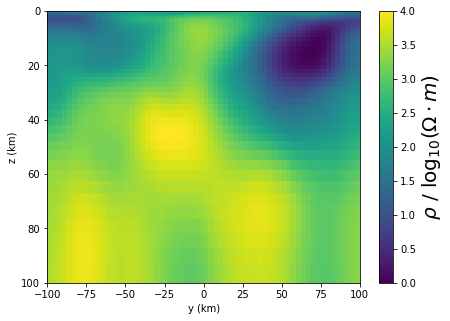

In [13]:
rho_id = 17

a_cof = x_normalizer.decode(x)[rho_id, ..., 0].cpu().numpy()
a_cof = np.log10(1/(10**a_cof))
rhoxy =    out[rho_id, ...,0].cpu().numpy()
phsxy = -1*out[rho_id, ...,1].cpu().numpy()
rhoyx =    out[rho_id, ...,2].cpu().numpy()
phsyx = -1*out[rho_id, ...,3].cpu().numpy()+180
rhoxy_true =    y[rho_id, ...,0].cpu().numpy()
phsxy_true = -1*y[rho_id, ...,1].cpu().numpy()
rhoyx_true =    y[rho_id, ...,2].cpu().numpy()
phsyx_true = -1*y[rho_id, ...,3].cpu().numpy()+180
rhoxy_fno  =    out_fno[rho_id, ...,0].cpu().numpy()
phsxy_fno  = -1*out_fno[rho_id, ...,1].cpu().numpy()
rhoyx_fno  =    out_fno[rho_id, ...,2].cpu().numpy()
phsyx_fno  = -1*out_fno[rho_id, ...,3].cpu().numpy()+180
rhoxy_cnn  =    out_cnn[rho_id, ...,0].cpu().numpy()
phsxy_cnn  = -1*out_cnn[rho_id, ...,1].cpu().numpy()
rhoyx_cnn  =    out_cnn[rho_id, ...,2].cpu().numpy()
phsyx_cnn  = -1*out_cnn[rho_id, ...,3].cpu().numpy()+180
# rhoxy_cnn2 = out_cnn2[i, ...,0].cpu().numpy()
# rhoyx_cnn2 = out_cnn2[i, ...,2].cpu().numpy()
# phsxy_cnn2 = out_cnn2[i, ...,1].cpu().numpy()
# phsyx_cnn2 = out_cnn2[i, ...,3].cpu().numpy()-180
print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy,rhoxy_true),error_r(rhoyx,rhoyx_true),error_r(phsxy,phsxy_true),error_r(phsyx,phsyx_true),)
print("Relative rhoxy_fno,rhoyx_fno, phsxy_fno,phsyx_fno  error: ", \
     error_r(rhoxy_fno,rhoxy_true),error_r(rhoyx_fno,rhoyx_true),error_r(phsyx_fno,phsyx_true),error_r(phsyx_fno,phsyx_true),)
print("Relative rhoxy_cnn,rhoyx_cnn, phsxy_cnn,phsyx_cnn  error: ", \
     error_r(rhoxy_cnn,rhoxy_true),error_r(rhoyx_cnn,rhoyx_true),error_r(phsyx_cnn,phsyx_true),error_r(phsyx_cnn,phsyx_true),)
# print("Relative rhoxy_cnn,rhoyx_cnn, phsxy_cnn,phsyx_cnn  error2: ", \
#      error_r(rhoxy_cnn2,rhoxy_true),error_r(rhoyx_cnn2,rhoyx_true),error_r(phsyx_cnn2,phsyx_true),error_r(phsyx_cnn2,phsyx_true),)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof, vmin=0,shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\rho$ / $\log_{10}(\Omega\cdot m)$",fontsize=20)# ax = plt.subplot(3,2,2)
# h=ax.pcolormesh(yn/1e3,zn/1e3,x_train0[i,...], shading='flat')
# ax.invert_yaxis()
# fig.colorbar(h)



In [14]:
plt.rcParams['font.family']       = 'arial' # 'Times New Roman' #
# plt.rcParams['axes.linewidth']    = 1
plt.rcParams['xtick.major.size']  = 2.
plt.rcParams['ytick.major.size']  = 2.5
plt.rcParams['xtick.minor.size']  = 1.5
plt.rcParams['ytick.minor.size']  = 1.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['lines.linewidth']   = 1.5
plt.rcParams['lines.markersize']  = 3.5

plt.rcParams['font.size']    = 10
# plt.rcParams['figure.titlesize'] = 2

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize']  = 7 # x, y label size
plt.rcParams['axes.titlesize'] = 7 # font size of the axes title
# plt.rcParams['legend.fontsize'] = 8
# plt.rcParams['legend.title_fontsize'] = 8

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams['image.cmap'] = 'jet_r'
plt.rcParams['figure.dpi'] = 150

In [15]:
cm = 1/2.54
obs_id = 9# idx of frequency
f_id = 5# idx of frequency
id_f = 40


# pad       = 6 # label pad between label and bar (value is relative to axis value?)  
text_size      = 7 # text size
bar_size       = 7 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
color_f        = 'black'
linestyle_f    = 'solid'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'right' # colorbar location relative to map
text_x_pos     = -135 # text location (value is relative to axis data in map)
text_y_pos     = 18.0 
rotation       = 0  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.
labelpad        = [6.5,3,6.5,3] # label pad between label and bar (value is relative to axis value?)  
pad            = 0.02 

bar_label = [r'$\mathit{\log_{10}\,\rho_{xy}\,(\Omega m)}$',r'$\phi_{xy}\,$(degree)',\
             r'$\mathit{\log_{10}\,\rho_{yx}\,(\Omega m)}$',r'$\phi_{yx}\,$(degree)']
x_label   = r'distance$\,$(km)'
y_label   = r'frequency$\,$(Hz)'

data_mesh = [[rhoxy_true,rhoxy,rhoxy_fno,rhoxy_cnn],
             [phsxy_true,phsxy,phsxy_fno,phsxy_cnn],
             [rhoyx_true,rhoyx,rhoyx_fno,rhoyx_cnn],
             [phsyx_true,phsyx,phsyx_fno,phsyx_cnn]
             ]
norm_rhoxy = colors.Normalize(vmin=np.min(data_mesh[0]),vmax=np.max(data_mesh[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data_mesh[1]),vmax=np.max(data_mesh[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data_mesh[2]),vmax=np.max(data_mesh[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data_mesh[3]),vmax=np.max(data_mesh[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]
title_out = ['FDM','EFNO','FNO','ECNN','cnn2']

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]

n_row,n_column = len(data_mesh[0]), len(data_mesh)
print(n_row,n_column)

4 4


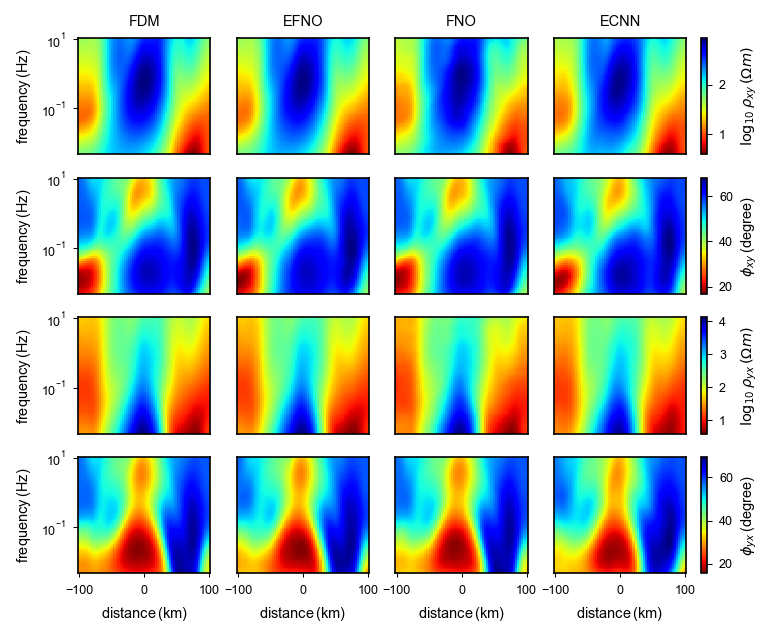

In [17]:
# plt.rcParams.update({
#     "font.family":'serif',
#     "mathtext.fontset":'stix',
#     "font.serif": ['arial'],
# })
figsize   = (4*n_row*cm,3*n_column*cm)
fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)

for j in range(n_column):
    for i in range(n_row):
        h = ax[i,j].pcolormesh(ry/1e3,freq,data_mesh[i][j],norm=norm[i], shading=shading)
#         ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
#         ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        ax[i,j].set_yscale("log")
    
        if j==0:
            ax[i,j].yaxis.tick_left()
            ax[i,j].yaxis.set_label_position("left")
            ax[i,j].set_ylabel(y_label)
        else:
            ax[i,j].set_yticks([])
        if j ==n_column-1:
            cbar = fig.colorbar(h,ax=[ax[i,jj] for jj in range(n_column)],location=loc,pad=pad)
            cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
        
        if i == 0:
            ax[i,j].set_title(title_out[j],fontsize=text_size)
        if i !=n_row-1:
            ax[i,j].set_xticks([])


    ax[i,j].set_xlabel(x_label)
    
# plt.savefig("../imags/compare"+".jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/compare"+".pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

frequency is: 0.18280434226738573s



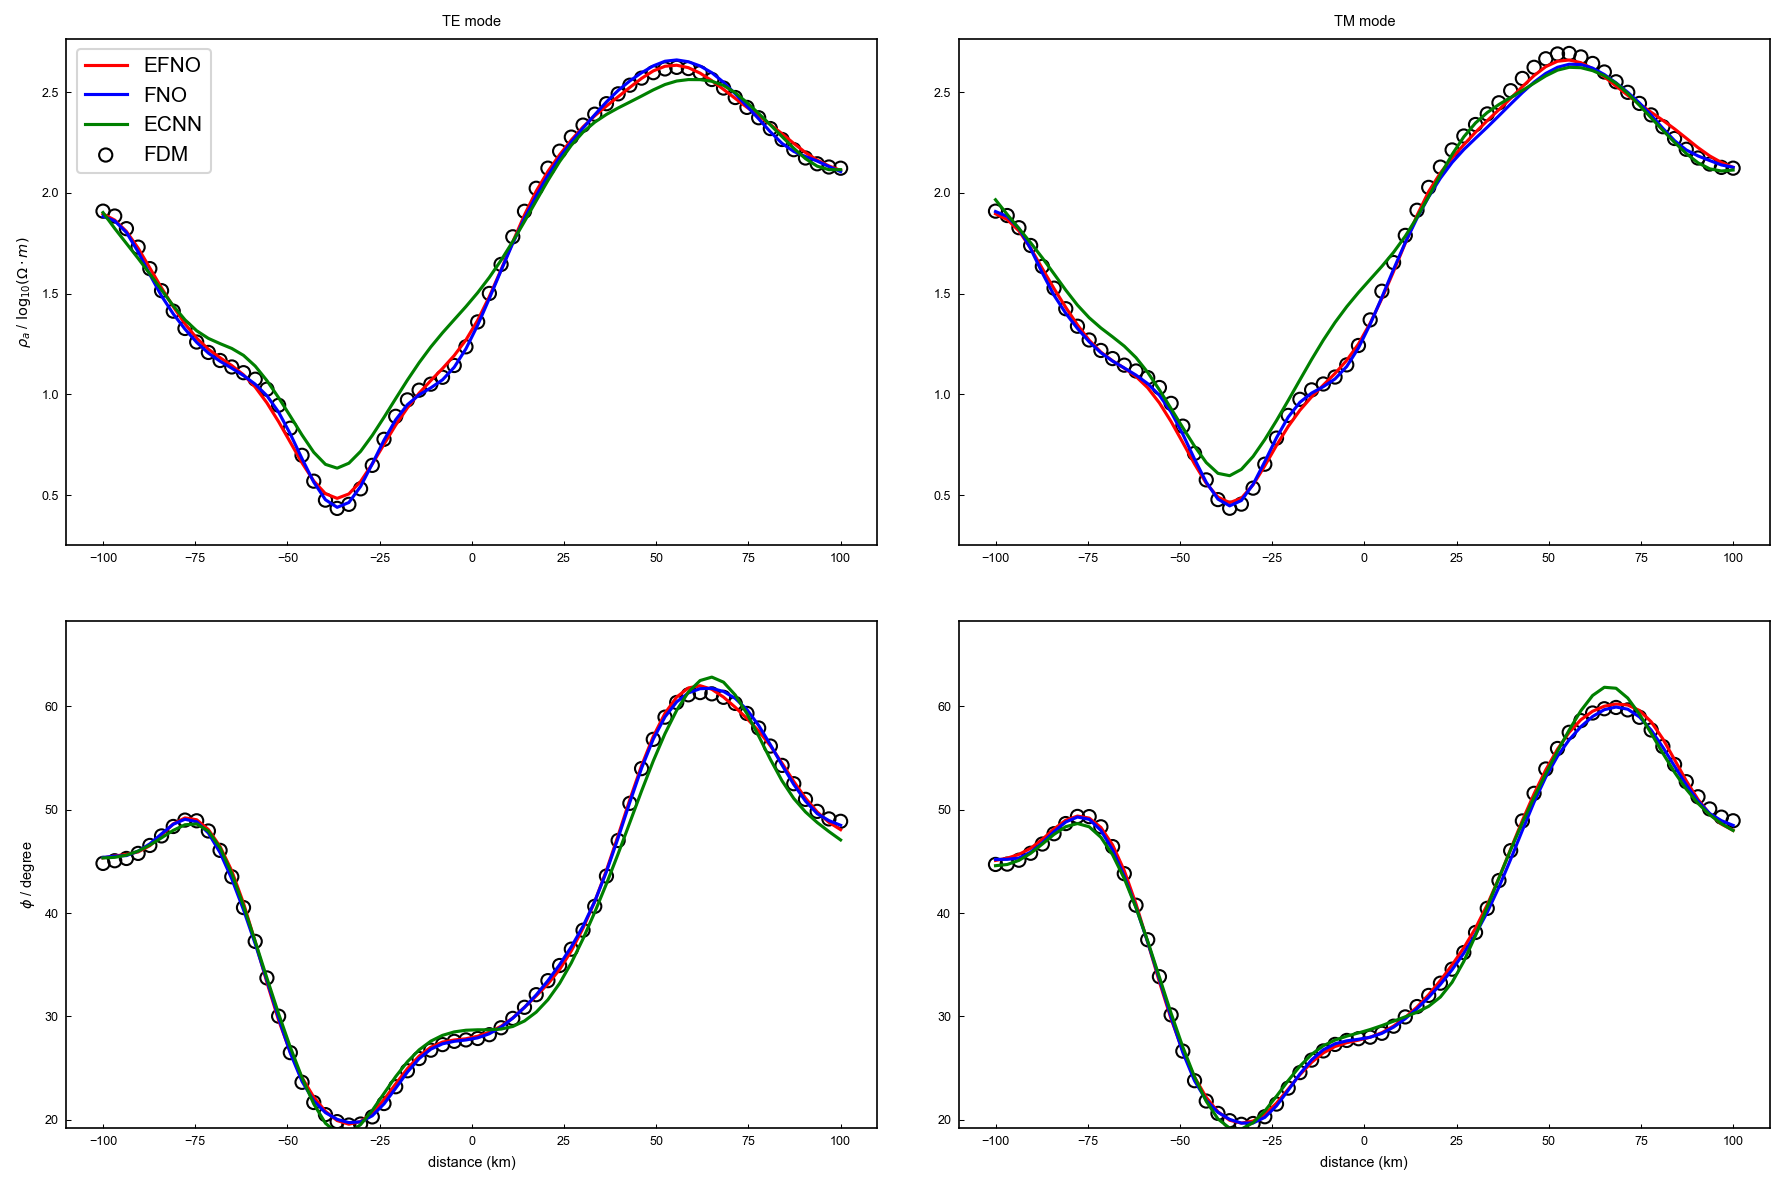

In [16]:
n_row,n_column = 2,2
figsize   = (12,8)

y_label = [r'$\rho_a$ / $\log_{10}(\Omega\cdot m)$',r"$\phi$ / degree"]
title   = ['TE mode','TM mode']
x_label = "distance (km)"

rho_min = np.min([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
rho_max = np.max([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
phs_min = np.min([phsxy_true,phsxy,phsyx_true,phsyx])
phs_max = np.max([phsxy_true,phsxy,phsyx_true,phsyx])
rho_lim = [rho_min,rho_max]
phs_lim = [phs_min,phs_max]
data1   = [[rhoxy_true[f_id,:],rhoyx_true[f_id,:]],[phsxy_true[f_id,:],phsyx_true[f_id,:]]]
data2   = [[rhoxy[f_id,:],rhoyx[f_id,:]],[phsxy[f_id,:],phsyx[f_id,:]]]
data3   = [[rhoxy_fno[f_id,:],rhoyx_fno[f_id,:]],[phsxy_fno[f_id,:],phsyx_fno[f_id,:]]]
data4   = [[rhoxy_cnn[f_id,:],rhoyx_cnn[f_id,:]],[phsxy_cnn[f_id,:],phsyx_cnn[f_id,:]]]

print(f"frequency is: {1.0/freq[f_id]}s")
print("")
fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        ax[i,j].scatter(ry/1e3, data1[i][j],color='None',marker='o',s=40,edgecolors='k',label=title_out[0])
        ax[i,j].plot(   ry/1e3, data2[i][j],color='r', linestyle='solid', marker='None',markersize=1,label=title_out[1])
        ax[i,j].plot(   ry/1e3, data3[i][j],color='b', linestyle='solid', marker='None',markersize=1,label=title_out[2])
        ax[i,j].plot(   ry/1e3, data4[i][j],color='g', linestyle='solid', marker='None',markersize=1,label=title_out[3])
#         ax[i,j].plot(ry/1e3, data3[i][j],color=' ', linestyle= 'None', marker='o',markersize=2,label='fine grid')
        ax[i,j].tick_params(axis='both',which='both',direction='in')
        if j==0:
            ax[i,j].set_ylabel(y_label[i])
        if i == 0:
            ax[i,j].set_title(title[j])
            ax[i,j].set_ylim(rho_lim)
#             ax[i,j].legend()
        elif i == n_row-1:
            ax[i,j].set_xlabel(x_label)
            ax[i,j].set_ylim(phs_lim)
        ax[0,0].legend()
fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.1, hspace =0.15)#调整子图间距
plt.show()        

observation station is: -71.42857142857143km



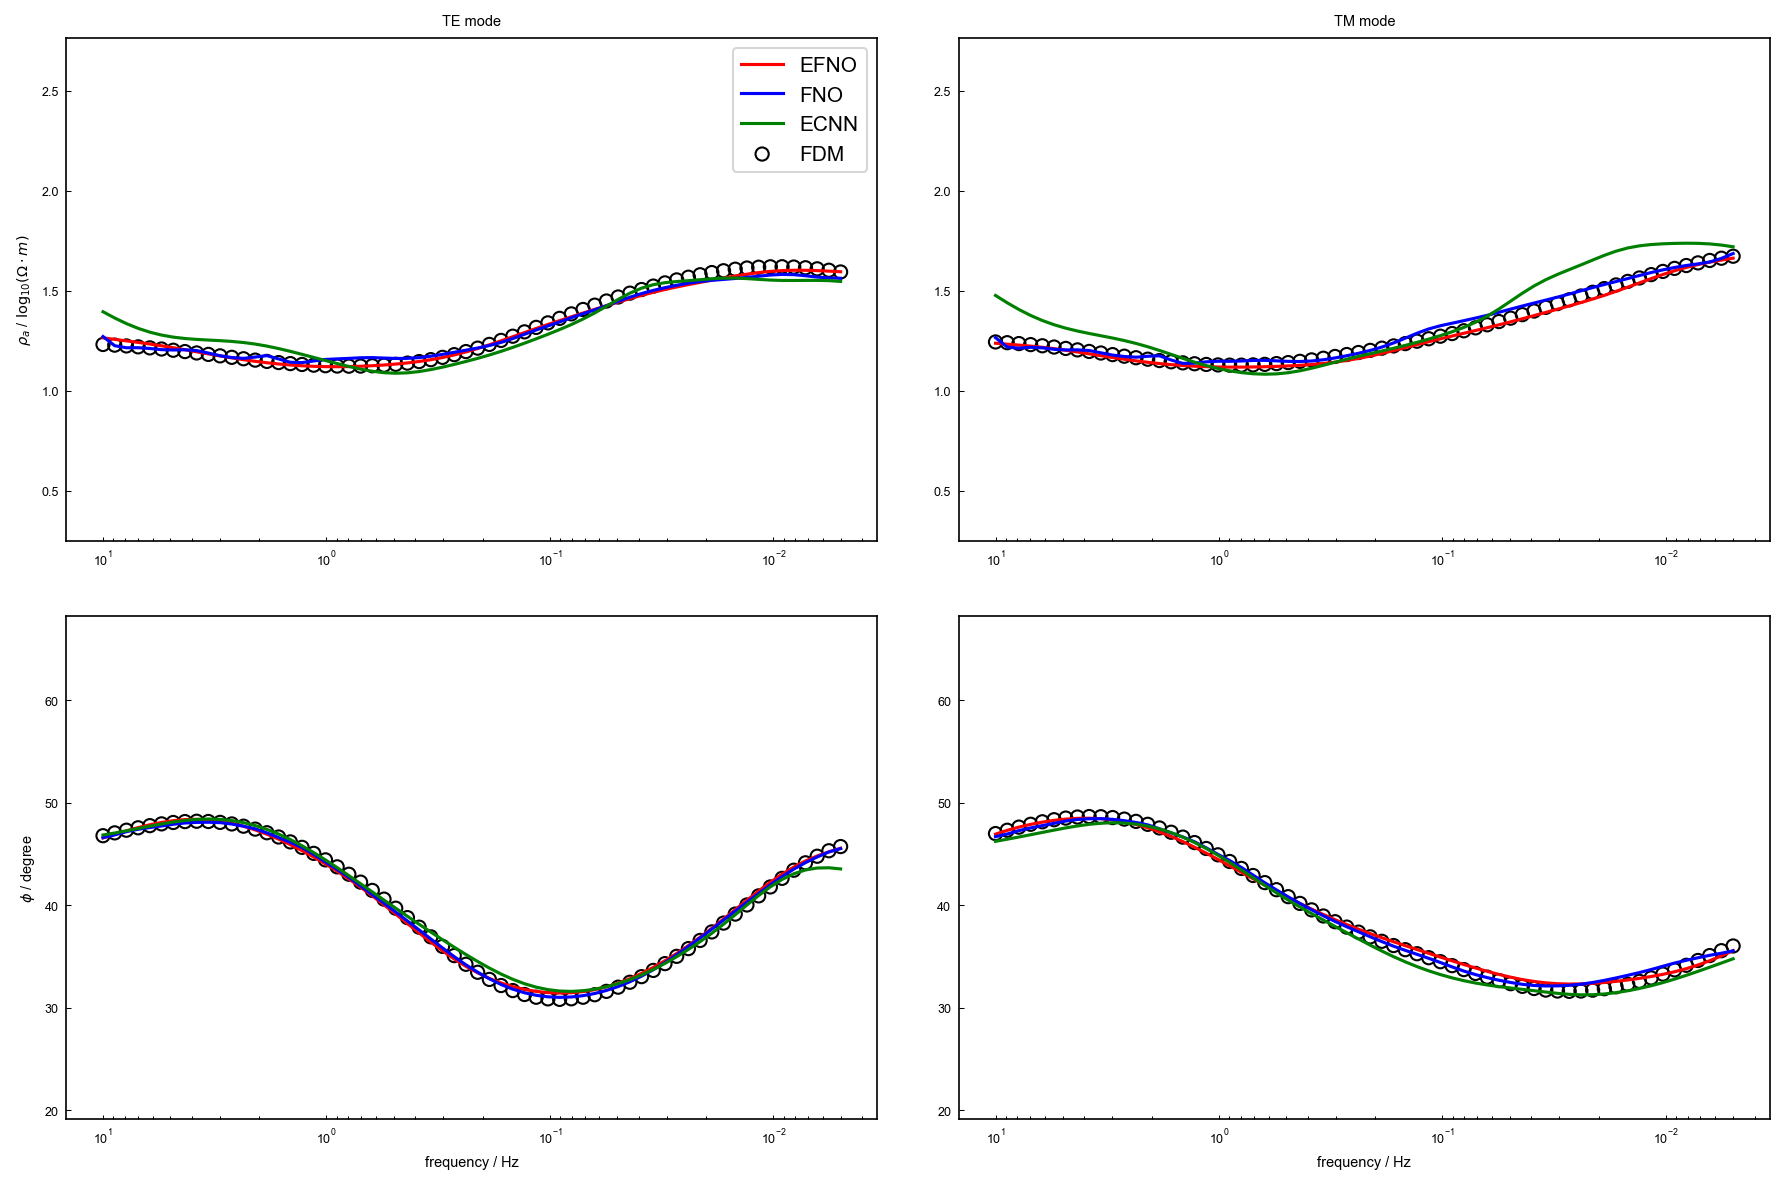

In [17]:
n_row,n_column = 2,2
figsize   = (12,8)

y_label = [r'$\rho_a$ / $\log_{10}(\Omega\cdot m)$',r"$\phi$ / degree"]
title   = ['TE mode','TM mode']
x_label = "frequency / Hz"
rho_min = np.min([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
rho_max = np.max([rhoxy_true,rhoxy,rhoyx_true,rhoyx])
phs_min = np.min([phsxy_true,phsxy,phsyx_true,phsyx])
phs_max = np.max([phsxy_true,phsxy,phsyx_true,phsyx])
rho_lim = [rho_min,rho_max]
phs_lim = [phs_min,phs_max]
data1   = [[rhoxy_true[:,obs_id],rhoyx_true[:,obs_id]],[phsxy_true[:,obs_id],phsyx_true[:,obs_id]]]
data2   = [[rhoxy[:,obs_id],rhoyx[:,obs_id]],[phsxy[:,obs_id],phsyx[:,obs_id]]]
data3   = [[rhoxy_fno[:,obs_id],rhoyx_fno[:,obs_id]],[phsxy_fno[:,obs_id],phsyx_fno[:,obs_id]]]
data4   = [[rhoxy_cnn[:,obs_id],rhoyx_cnn[:,obs_id]],[phsxy_cnn[:,obs_id],phsyx_cnn[:,obs_id]]]

print(f"observation station is: {ry[obs_id]/1e3}km")
print("")
fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        ax[i,j].scatter(freq, data1[i][j],color='None',marker='o',s=40,edgecolors='k',label=title_out[0])
        ax[i,j].plot(   freq, data2[i][j],color='r', linestyle='solid', marker='None',markersize=1,label=title_out[1])
        ax[i,j].plot(   freq, data3[i][j],color='b', linestyle='solid', marker='None',markersize=1,label=title_out[2])
        ax[i,j].plot(   freq, data4[i][j],color='g', linestyle='solid', marker='None',markersize=1,label=title_out[3])
#         ax[i,j].plot(ry/1e3, data3[i][j],color=' ', linestyle= 'None', marker='o',markersize=2,label='fine grid')
        ax[i,j].invert_xaxis()
        ax[i,j].set_xscale("log")
        ax[i,j].tick_params(axis='both',which='both',direction='in')
        if j==0:
            ax[i,j].set_ylabel(y_label[i])
        if i == 0:
            ax[i,j].set_title(title[j])
            ax[i,j].set_ylim(rho_lim)
#             ax[i,j].set_aspect(1) # same scale
#             ax[i,j].legend()
        elif i == n_row-1:
            ax[i,j].set_xlabel(x_label)
            
            ax[i,j].set_ylim(phs_lim)
        ax[0,0].legend()
fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.1, hspace =0.15)#调整子图间距
plt.show()        